# Kalman Filter and Newton's Law of Cooling

---

## Problem Definition

Suppose a (simplified) dynamic system that models the heating of a house as illustrated in the figure below; inspired by [[1](https://www.sharetechnote.com/html/DE_Modeling_Example_Cooling.html)].

![house](newton_cooling.svg)

- $T_A$...temperature of the **attic**
- $T_S$...temperature of the **surrounding**
- $T_E$...temperature of the **earth**
- $T_H$...temperature of the **heater** 
- $T_M$...temperature of the **main floor**
- $k_1,k_2,k_3,k_4,k_5$...coefficients of heat transfer

Based on [Newton's law of cooling](https://en.wikipedia.org/wiki/Newton%27s_law_of_cooling), this situation can be modeled by a system of two linear ODEs:

$$ 
\left\{\begin{array}{rl}
        T_M' &= k_1(T_M-T_E) + k_2(T_M-T_S) + k_3(T_M-T_A) + k_5(T_M-T_H),\\
        T_A' &= k_3(T_A-T_M) + k_4(T_A-T_S).
\end{array}\right.
$$

The goal is to design a Kalman filter to accommodate inaccurate temperature measurements.

In [37]:
# Imports
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from MyKalman import KF

## Numerical Solution 

First, we shall test the model using [`scipy.integrate.solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy-integrate-solve-ivp), which is the `scipy` implementation of RK45.

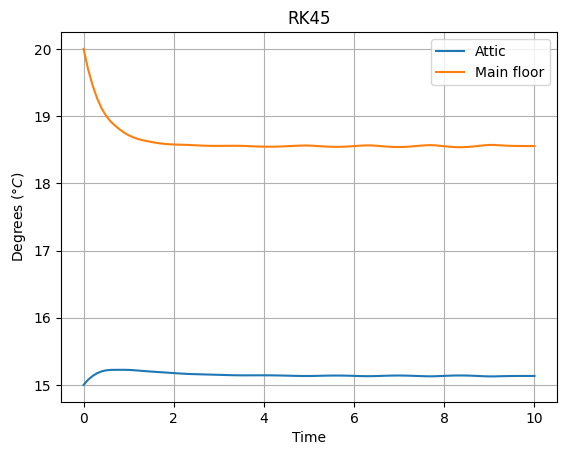

In [38]:
def odes(t, y, k1, k2, k3, k4, k5, Ts, Te, Th):
    Ta, Tm = y

    dTa = k3 * (Ta - Tm) + k4 * (Ta - Ts)
    dTm = k1 * (Tm - Te) + k2 * (Tm - Ts) + k3 * (Tm - Ta) + k5 * (Tm - Th)

    return [dTa, dTm]


# Define the constants
k1 = -0.6
k2 = -0.7
k3 = -0.5
k4 = -0.8
k5 = -0.5
Ts = 13
Te = 10
Th = 40

# Define the initial conditions
initial_conditions = [15, 20]  # [Ta(0), Tm(0)]

# Define the time span
t_start = 0.0
t_end = 10.0
t_step = 0.1
t_span = (t_start, t_end)

# Solve the ODEs
solution = solve_ivp(odes, t_span, initial_conditions, args=(
    k1, k2, k3, k4, k5, Ts, Te, Th), method='RK45', t_eval=np.arange(t_start, t_end + t_step, t_step))

# Access the solution
time = solution.t
Ta_values = solution.y[0]
Tm_values = solution.y[1]

fig = plt.figure()
plt.plot(time, Ta_values, label="Attic")
plt.plot(time, Tm_values, label="Main floor")
plt.legend()
plt.grid(True)
plt.title("RK45")
plt.ylabel("Degrees $(°C)$")
plt.xlabel("Time")
plt.show()


The above example represents a situation where the heater is on and never turns off. Let us define $T_H$ to be non-constant; e.g. $T_H(k)=10 + 5\cos (0.1 k)$. For example, this can simulate a situation where the heating is turned off during the night.

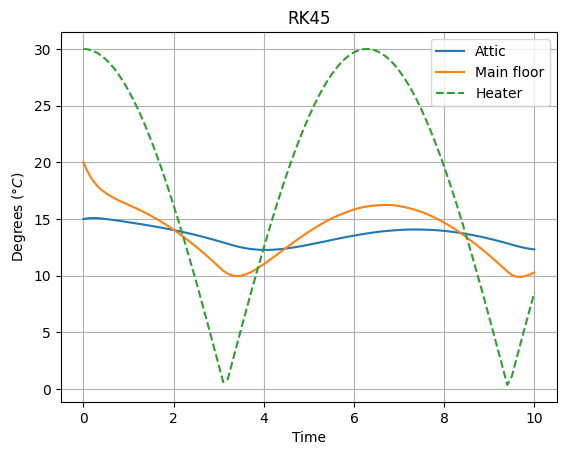

In [39]:
def odes2(t, y, k1, k2, k3, k4, k5, Ts, Te):
    Ta, Tm = y

    Th = heater(t)  # Time-dependent Th

    dTa = k3 * (Ta - Tm) + k4 * (Ta - Ts)
    dTm = k1 * (Tm - Te) + k2 * (Tm - Ts) + k3 * (Tm - Ta) + k5 * (Tm - Th)

    return [dTa, dTm]


# Define the constants
k1 = -0.8
k2 = -0.95
k3 = -0.5
k4 = -0.8
k5 = -0.7
Ts = 13
Te = 10

# Define the heater function
heater = lambda t: np.abs(30*np.cos(0.5 * t))

# Define the initial conditions
initial_conditions = [15, 20]  # [Ta(0), Tm(0)]

# Define the time span
t_start = 0.0
t_end = 10.0
t_step = 0.1
t_span = (t_start, t_end)

# Solve the ODEs
solution = solve_ivp(odes2, t_span, initial_conditions, args=(
    k1, k2, k3, k4, k5, Ts, Te), method='RK45', t_eval=np.arange(t_start, t_end + t_step, t_step))

# Access the solution
time = solution.t
Ta_values = solution.y[0]
Tm_values = solution.y[1]

fig = plt.figure()
plt.plot(time, Ta_values, label="Attic")
plt.plot(time, Tm_values, label="Main floor")
plt.plot(time, heater(time), label="Heater", linestyle="dashed")
plt.legend()
plt.grid(True)
plt.title("RK45")
plt.ylabel("Degrees $(°C)$")
plt.xlabel("Time")
plt.show()


We now try to solve this problem using [Euler's method](https://en.wikipedia.org/wiki/Euler_method):

$$
\begin{align*}
T_M(k+\Delta) &= T_M(k) + \Delta [k_1\left(T_M(k)-T_E\right) + k_2\left(T_M(k)-T_S\right) + k_3\left(T_M(k)-T_A(k)\right) + k_5\left(T_M(k) - T_H\right)],\\
T_A(k+\Delta) &= T_A(k) + \Delta [k_3\left(T_A(k)-T_M(k)\right) + k_4\left(T_A(k)-T_S\right)],
\end{align*}
$$

where $\Delta$ denotes the step size and $k$ represents the discrete step.

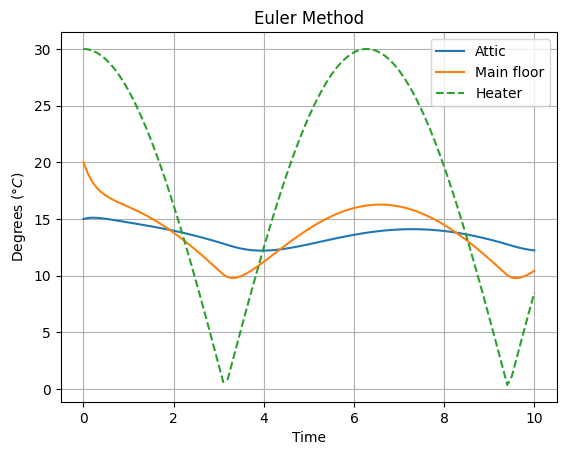

In [40]:
def solve_odes_euler(y0, k1, k2, k3, k4, k5, Ts, Te, t_start, t_end, t_step):
    # Define the initial conditions
    Ta = y0[0]
    Tm = y0[1]

    # Create arrays to store the time and variable values
    time = np.arange(t_start, t_end + t_step, t_step)
    Ta_values = np.zeros(len(time))
    Tm_values = np.zeros(len(time))

    # Set the initial values
    Ta_values[0] = Ta
    Tm_values[0] = Tm

    # Iterate over the time array using Euler's method
    for i in range(1, len(time)):
        t = time[i]

        # Calculate Th at the current time
        Th = heater(t)

        # Calculate the derivatives
        dTa = k3 * (Ta - Tm) + k4 * (Ta - Ts)
        dTm = k1 * (Tm - Te) + k2 * (Tm - Ts) + k3 * (Tm - Ta) + k5 * (Tm - Th)

        # Update the variable values using Euler's method
        Ta += t_step * dTa
        Tm += t_step * dTm

        # Store the variable values in the arrays
        Ta_values[i] = Ta
        Tm_values[i] = Tm

    return time, Ta_values, Tm_values

# Define the constants
k1 = -0.8
k2 = -0.95
k3 = -0.5
k4 = -0.8
k5 = -0.7
Ts = 13
Te = 10

# Define the heater function
heater = lambda t: np.abs(30*np.cos(0.5 * t))

# Define the initial conditions
y0 = [15, 20]  # [Ta(0), Tm(0)]

# Define the time span and step size
t_start = 0.0
t_end = 10.0
t_step = 0.1

# Solve the ODEs using Euler's method
time, Ta_values, Tm_values = solve_odes_euler(
    y0, k1, k2, k3, k4, k5, Ts, Te, t_start, t_end, t_step)

fig = plt.figure()
plt.plot(time, Ta_values, label="Attic")
plt.plot(time, Tm_values, label="Main floor")
plt.plot(time, heater(time), label="Heater", linestyle="dashed")
plt.legend()
plt.grid(True)
plt.title("Euler Method")
plt.ylabel("Degrees $(°C)$")
plt.xlabel("Time")
plt.show()


We obtained the same results. However, when the `t_step` is higher, e.g. `t_step=0.9`, Euler's method diverges.

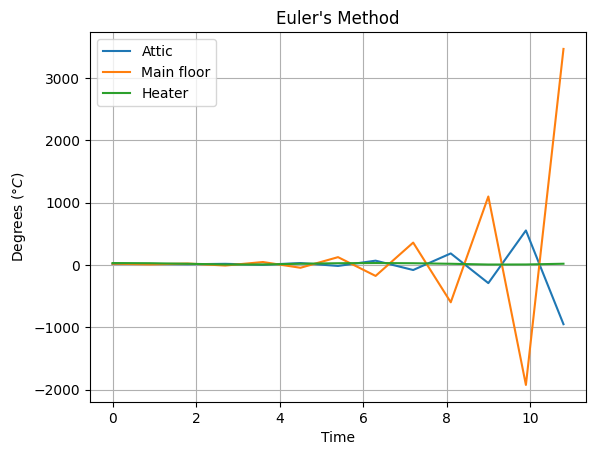

In [41]:
time, Ta_values, Tm_values = solve_odes_euler(
    y0, k1, k2, k3, k4, k5, Ts, Te, t_start, t_end, t_step=0.9)

fig = plt.figure()
plt.plot(time, Ta_values, label="Attic")
plt.plot(time, Tm_values, label="Main floor")
plt.plot(time, heater(time), label="Heater")
plt.legend()
plt.grid(True)
plt.title("Euler's Method")
plt.ylabel("Degrees $(°C)$")
plt.xlabel("Time")
plt.show()


Since Euler's method diverges, we can try a more robust method; namely [Heun's method](https://en.wikipedia.org/wiki/Heun%27s_method) (two step RK): 

$$
\begin{align*}
\tilde{y}_{i+1} &= y_i + h f(t_i,y_i),\\
y_{i+1} &= y_i + \frac{h}{2}[f(t_i, y_i) + f(t_{i+1},\tilde{y}_{i+1})],
\end{align*}
$$

where $h$ is the step size and $t_{i+1}=t_{i+h}$.

We denote the step size as $\Delta$ and the discrete step as $k$. In the case of our problem, we obtain the following:

$$
\begin{align*}
\tilde{T}_M(k+\Delta) &= T_M(k) + \Delta [k_1\left(T_M(k)-T_E\right) + k_2\left(T_M(k)-T_S\right) + k_3\left(T_M(k)-T_A(k)\right) + k_5\left(T_M(k) - T_H\right)],\\
T_M(k+\Delta) &= T_M(k) + \frac{\Delta}{2} \left[\tilde{T}_M(k+\Delta) + k_1\left(\tilde{T}_M(k+\Delta)-T_E\right) + k_2\left(\tilde{T}_M(k+\Delta)-T_S\right) + k_3\left(\tilde{T}_M(k+\Delta)-T_A(k+\Delta)\right)  + k_5 \left(\tilde{T}_M(k+\Delta)-T_H\right)\right],\\
\tilde{T}_A(k+\Delta) &= T_A(k) + \Delta [k_3\left(T_A(k)-T_M\right) + k_4\left(T_A(k)-T_S\right)],\\
T_A(k+\Delta) &= T_A(k) + \frac{\Delta}{2} \left[\tilde{T}_A(k+\Delta) + k_3\left(\tilde{T}_A(k+\Delta)-T_M(k+\Delta)\right) + k_4\left(\tilde{T}_A(k+\Delta)-T_S\right)\right].
\end{align*}
$$

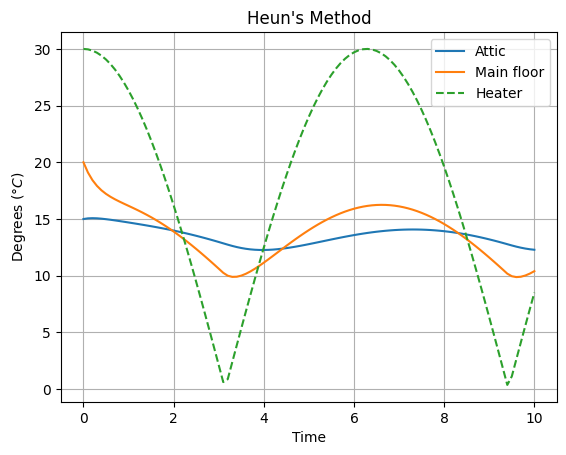

In [42]:
def solve_odes_heun(y0, k1, k2, k3, k4, k5, Ts, Te, t_start, t_end, t_step):
    # Define the initial conditions
    Ta = y0[0]
    Tm = y0[1]

    # Create arrays to store the time and variable values
    time = np.arange(t_start, t_end + t_step, t_step)
    Ta_values = np.zeros(len(time))
    Tm_values = np.zeros(len(time))

    # Set the initial values
    Ta_values[0] = Ta
    Tm_values[0] = Tm

    # Iterate over the time array using Heun's method
    for i in range(1, len(time)):
        t = time[i]

        # Calculate Th at the current time
        Th = heater(t)

        # Calculate the derivatives at the current time
        dTa = k3 * (Ta - Tm) + k4 * (Ta - Ts)
        dTm = k1 * (Tm - Te) + k2 * (Tm - Ts) + k3 * (Tm - Ta) + k5 * (Tm - Th)

        # Estimate the values at the next time step using Heun's method
        Ta_pred = Ta + t_step * dTa
        Tm_pred = Tm + t_step * dTm

        # Calculate the derivatives at the predicted values
        dTa_pred = k3 * (Ta_pred - Tm_pred) + k4 * (Ta_pred - Ts)
        dTm_pred = k1 * (Tm_pred - Te) + k2 * (Tm_pred - Ts) + k3 * (Tm_pred - Ta_pred) + k5 * (Tm - Th)

        # Update the variable values using Heun's method
        Ta += 0.5 * t_step * (dTa + dTa_pred)
        Tm += 0.5 * t_step * (dTm + dTm_pred)

        # Store the variable values in the arrays
        Ta_values[i] = Ta
        Tm_values[i] = Tm

    return time, Ta_values, Tm_values


# Define the constants
k1 = -0.8
k2 = -0.95
k3 = -0.5
k4 = -0.8
k5 = -0.7
Ts = 13
Te = 10

# Define the heater function
heater = lambda t: np.abs(30*np.cos(0.5 * t))

# Define the initial conditions
y0 = [15, 20]  # [Ta(0), Tm(0)]

# Define the time span and step size
t_start = 0.0
t_end = 10.0
t_step = 0.1

# Solve the ODEs using Heun's method
time, Ta_values, Tm_values = solve_odes_heun(
    y0, k1, k2, k3, k4, k5, Ts, Te, t_start, t_end, t_step)

fig = plt.figure()
plt.plot(time, Ta_values, label="Attic")
plt.plot(time, Tm_values, label="Main floor")
plt.plot(time, heater(time), label="Heater", linestyle="dashed")
plt.legend()
plt.grid(True)
plt.title("Heun's Method")
plt.ylabel("Degrees $(°C)$")
plt.xlabel("Time")
plt.show()


Nevertheless, similar to Euler's method, when the `t_step` is higher, e.g. `t_step=0.9`, Heun's method diverges.

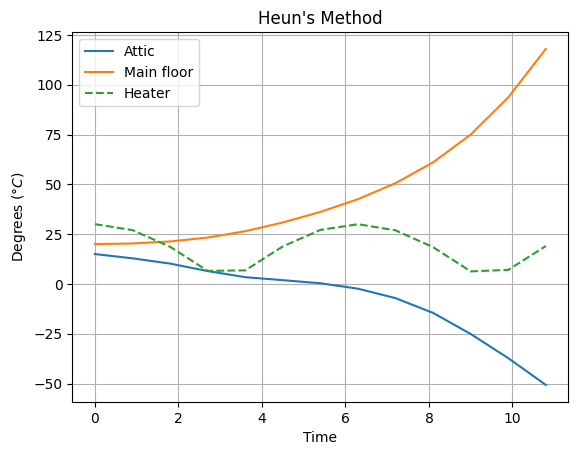

In [43]:
time, Ta_values, Tm_values = solve_odes_heun(
    y0, k1, k2, k3, k4, k5, Ts, Te, t_start, t_end, t_step=0.9)

fig = plt.figure()
plt.plot(time, Ta_values, label="Attic")
plt.plot(time, Tm_values, label="Main floor")
plt.plot(time, heater(time), label="Heater", linestyle="dashed")
plt.legend()
plt.grid(True)
plt.title("Heun's Method")
plt.ylabel("Degrees $(°C)$")
plt.xlabel("Time")
plt.show()


## Kalman Filter

Thus far, we have presented an exact model. However,  when dealing with real-world problems, there is often inherent noise present in measurements, and no mathematical model can achieve complete accuracy. Additionally, our current model overlooks certain aspects like roof and wall areas (the heat transfer surface), leading to process noise as the model fails to fully incorporate reality.

Kalman filter can be summarized using the following equations:

$\begin{array}{|l|l|}
\hline
\text{Prediction} & \text{Update}\\
\hline
\hat{\mathbf{x}}=\mathbf{F}\mathbf{x}+\mathbf{B}\mathbf{u} & \mathbf{y}=\mathbf{z}-\mathbf{H}\hat{\mathbf{x}} \\
\hat{\mathbf{P}}=\mathbf{F}\mathbf{P}\mathbf{F}^\mathsf{T}+\mathbf{Q} & \hat{\mathbf{K}}=\hat{\mathbf{P}}\mathbf{H}^\mathsf{T}(\mathbf{H}\hat{\mathbf{P}}\mathbf{H}^\mathsf{T}+\mathbf{R})^{-1}  \\
& \mathbf{x}=\hat{\mathbf{x}}+\mathbf{K}\mathbf{y}\\
& \mathbf{P}=(\mathbf{I}-\mathbf{K}\mathbf{H})\hat{\mathbf{P}}\\
\hline
\end{array}$

We define the vector 

$$ \mathbf{x} = \begin{bmatrix} T_A & T_M & T_H & T_E & T_S \end{bmatrix}^T $$

to encompass the states of the Kalman filter. 

In [44]:
Ta, Tm, Th, Te, Ts = 15, 20, 30, 10, 13 
x = np.array([Ta, Tm, Th, Te, Ts])

The heater temperature $T_H$, earth temperature $T_E$, and the temperature of the surrounding $T_S$ are considered as the input to the system, that is:

$$u = \begin{bmatrix} T_H & T_E & T_S \end{bmatrix}^T,$$ 

and the corresponding *input control matrix*:

$$
B = \begin{bmatrix} 
0 & 0 & 0\\
0 & 0 & 0\\ 
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1\\
\end{bmatrix}.
$$

In [45]:
# Heater function
heater = lambda t: np.abs(20*np.cos(0.5 * t)) + 10

# Input vector
u = lambda t: np.array([heater(t), Te, Ts]).T

# Input control matrix
B = np.zeros((5,3))
B[2:,:]=np.eye(3)

The temperature of the attic $T_A$ and main floor $T_M$ are measured with a thermometer, which has *standard deviation* $\sigma=1°C$. The *observation matrix* $H$ is as follows:

$$
H = \begin{bmatrix} 1 & 0 & 0 & 0 & 0\\
                    0 & 1 & 0 & 0 & 0
\end{bmatrix}
$$

and the corresponding *measurement covariance matrix* $R$ can be written as:

$$
R = \begin{bmatrix} 1^2 & 0 \\
                    0 & 1^2 
\end{bmatrix}.
$$

In [46]:
H = np.array([[1, 0, 0, 0, 0],
              [0, 1, 0, 0, 0]])
std = 1
R = (std**2) * np.eye(2)

The heat transfer coefficients $k_1, k_2,\dots, k_5$ are assumed to be predetermined constants.

In [47]:
k1 = -0.8
k2 = -0.95
k3 = -0.5
k4 = -0.8
k5 = -0.7

Approximations from Heun's method are too complex for presentation purposes (actually quite unreadable), therefore, we use **Euler's method** instead:

$$
\begin{align*}
T_A(k+\Delta) &= T_A(k) + \Delta [k_3\left(T_A(k)-T_M\right) + k_4\left(T_A(k)-T_S\right)]\\
T_M(k+\Delta) &= T_M(k) + \Delta [k_1\left(T_M(k)-T_E\right) + k_2\left(T_M(k)-T_S\right) + k_3\left(T_M(k)-T_A(k)\right) + k_5(T_M-T_H)]
\end{align*}
$$
---
$$
\begin{align*}
T_{A} \left( k+\Delta \right) &= \left( 1+ \left( k_{3}+k_{4} \right) 
\Delta \right) T_{A} \left( k \right) -\Delta\, \left( k_{4}\,T_{S}+k_
{3}\,T_{M} \left( k \right)  \right)\\
T_M(k+\Delta) &= \left( 1+ \left( k_{1}+k_{2}+k_{3}+k_{5} \right) \Delta \right) T_{M}
 \left( k \right) -\Delta\, \left( k_{3}\,T_{A} \left( k \right) +k_{1
}\,T_{E}+k_{5}\,T_{H}+k_{2}\,T_{S} \right)
\end{align*}
$$

We can write the *state extrapolation equation* with *state-transition matrix* $F$ as follows:

$$
\hat{\mathbf{x}} = \underbrace{\begin{bmatrix}
1+ ( k_{3}+k_{4} ) \Delta & -\Delta k_3 & 0 & 0 & -\Delta k_4\\
-\Delta k_3 & 1 + (k_1+k_2+k_3+k_5)\Delta & - \Delta k_5 & -\Delta k_1 & -\Delta k_2\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
\end{bmatrix}}_{F=A}
\underbrace{\begin{bmatrix} T_A \\ T_M \\ T_H \\ T_E \\ T_S \end{bmatrix}}_{x}
+Bu
$$

In [48]:
dt = 0.1 # Delta
F = np.array([[1 + (k3+k4)*dt, -dt*k3, 0, 0, -dt*k4],
              [-dt*k3, 1+(k1+k2+k3+k5)*dt, -dt*k5, -dt*k1, -dt*k2],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0]])

The only remaining matrices to be defined are $P=\Sigma$ (covariance) and $Q$ (process noise).

In [49]:
P = np.diag(np.power([10,10,0,0,0],2)) # +- 10°C
#Q = np.zeros((5,5)) # no process noise
Q = (0.01**2) * np.eye(5)

We generate true and noisy measurements using Euler's method.

In [50]:
# Define the time span and step size
t_start = 0.0
t_end = 15.0
t_step = dt

# Generate true and noisy observations
time, Ta_values, Tm_values = solve_odes_euler(
    [Ta,Tm], k1, k2, k3, k4, k5, Ts, Te, t_start, t_end, t_step)

noise_Ta = np.random.normal(0.0, 1, size=len(Ta_values))
noise_Tm = np.random.normal(0.0, 1, size=len(Ta_values))
Ta_noisy = Ta_values + noise_Ta
Tm_noisy = Tm_values + noise_Tm

Afterwards, we plot the noisy data.

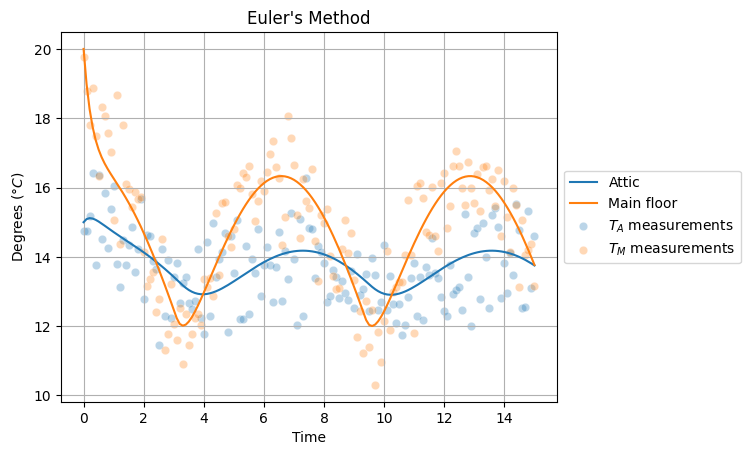

In [51]:
fig = plt.figure()
plt.plot(time, Ta_values, label="Attic")
plt.plot(time, Tm_values, label="Main floor")
sns.scatterplot(x=time, y=Ta_noisy,alpha=0.3, label="$T_A$ measurements")
sns.scatterplot(x=time, y=Tm_noisy,alpha=0.3, label="$T_M$ measurements")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.title("Euler's Method")
plt.ylabel("Degrees $(°C)$")
plt.xlabel("Time")
plt.show()

Eventually, we are ready to employ the Kalman filter.

In [52]:
# Stack noisy measurements into a matrix
zs = np.vstack([Ta_noisy, Tm_noisy]).T

# Create Kalman filter object and assign all required parameters
kf = KF(F=F, P=P, Q=Q, H=H, R=R, x=x, zs=zs, B=B, u=u, dt=dt)

# Run simulation
xs, cov, ks = kf.run()

Subsequently, we plot the results.

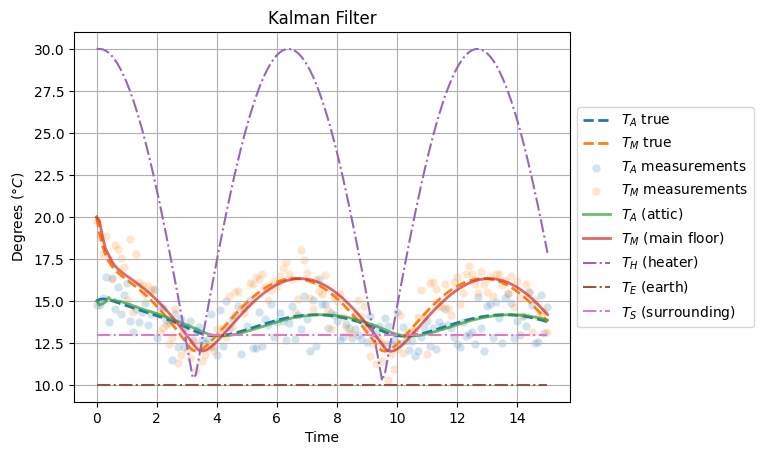

In [53]:
fig = plt.figure()
#fig = plt.figure(figsize=(8,5),dpi=300)
plt.plot(time, Ta_values, label="$T_A$ true",linestyle="dashed", linewidth = 2)
plt.plot(time, Tm_values, label="$T_M$ true",linestyle="dashed", linewidth = 2)
sns.scatterplot(x=time, y=Ta_noisy,alpha=0.2, label="$T_A$ measurements")
sns.scatterplot(x=time, y=Tm_noisy,alpha=0.2, label="$T_M$ measurements")
plt.plot(time, xs[0:-1,0], label="$T_A$ (attic)", linewidth = 2, alpha=0.7)
plt.plot(time, xs[0:-1,1], label="$T_M$ (main floor)", linewidth = 2, alpha=0.7)
plt.plot(time, xs[0:-1,2], label="$T_H$ (heater)", linestyle="dashdot")
plt.plot(time, xs[0:-1,3], label="$T_E$ (earth)", linestyle="dashdot")
plt.plot(time, xs[0:-1,4], label="$T_S$ (surrounding)", linestyle="dashdot")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.title("Kalman Filter")
plt.ylabel("Degrees $(°C)$")
plt.xlabel("Time")
#plt.savefig("kalman_filter.svg", bbox_inches='tight')
plt.show()

### Plot final covariance matrix

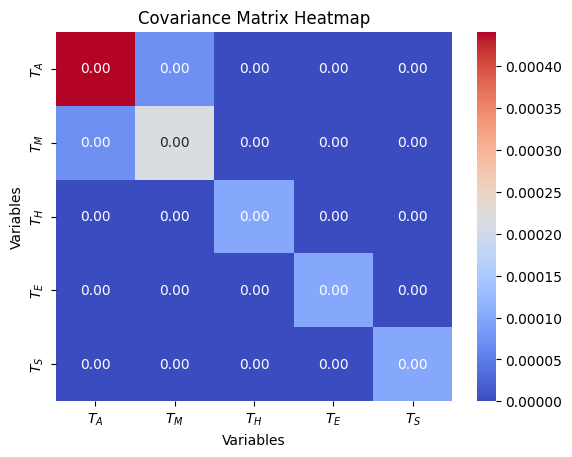

In [54]:
fig, ax = plt.subplots()
labels = ['$T_A$', '$T_M$', '$T_H$', '$T_E$', '$T_S$']
sns.heatmap(cov[-1, :, :], annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title("Covariance Matrix Heatmap")
ax.set_xlabel("Variables")
ax.set_ylabel("Variables")
plt.show()

### Plot residuals

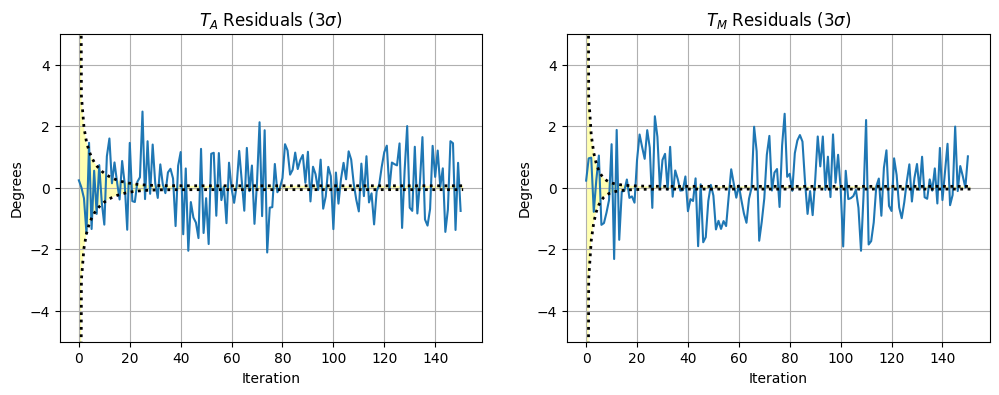

In [55]:
true_values = np.vstack([Ta_noisy, Tm_noisy]).T

def plot_residual_limits(Ps, axs, stds=1.):
    std = np.sqrt(Ps) * stds
    axs.plot(-std, color='k', ls=':', lw=2)
    axs.plot(std, color='k', ls=':', lw=2)
    axs.fill_between(range(len(std)), -std, std,
                 facecolor='#ffff00', alpha=0.3)
    
def plot_residuals(xs, data, cov, cols, titles="", y_label="", stds=1):
    
    if len(titles) < len(cols):
        titles = [""] * len(cols)
    
    fig, axs = plt.subplots(1, len(cols), figsize=(12, 4))

    for i, col in enumerate(cols):
        res = xs[:-1, col] - data[:, col]
        axs[i].plot(res)
        plot_residual_limits(cov[:, col, col], axs[i], stds)
        axs[i].set_xlabel('Iteration')
        axs[i].set_ylabel(y_label)
        axs[i].set_title(titles[i])
        axs[i].grid(True)
        axs[i].set_ylim(-5,5)

    plt.show()

plot_residuals(xs, true_values, cov, [0, 1],
               titles=['$T_A$ Residuals (3$\sigma$)',
                       '$T_M$ Residuals (3$\sigma$)'],
               y_label="Degrees", stds=3)

### Plot Kalman gain

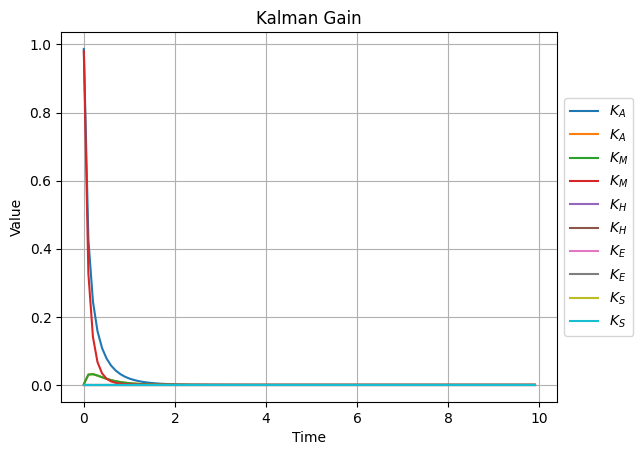

In [56]:
fig = plt.figure()
n = 100
plt.plot(time[:n], ks[:n,0], label="$K_A$")
plt.plot(time[:n], ks[:n,1], label="$K_M$")
plt.plot(time[:n], ks[:n,2], label="$K_H$")
plt.plot(time[:n], ks[:n,3], label="$K_E$")
plt.plot(time[:n], ks[:n,4], label="$K_S$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.title("Kalman Gain")
plt.ylabel("Value")
plt.xlabel("Time")
plt.show()

### What if we change the input vector to something more interesting?

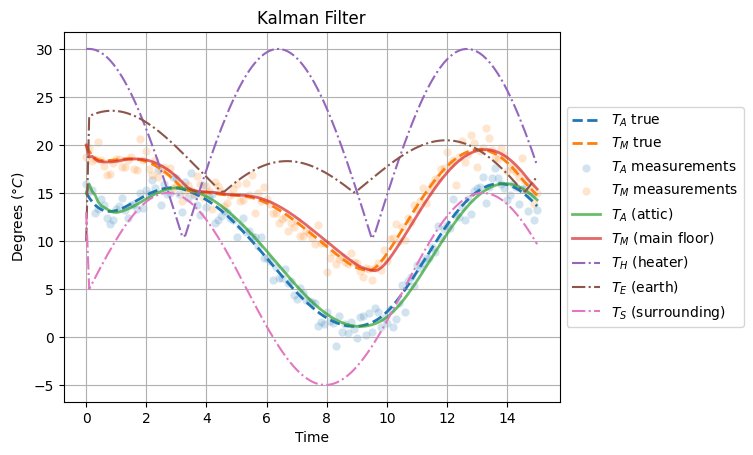

In [57]:
# Define input functions
heater = lambda t: np.abs(20*np.cos(0.5 * t)) + 10
outside = lambda t: 10*np.sin(0.6 * t) + 5
earth = lambda t: np.abs(5*np.sin(0.3 * t) + 8*np.cos(0.5 * t)) + 15

# Define input vector
u = lambda t: np.array([heater(t), earth(t), outside(t)]).T

# Generate true and noisy data
def solve_odes_euler2(y0, k1, k2, k3, k4, k5, t_start, t_end, t_step):
    # Define the initial conditions
    Ta = y0[0]
    Tm = y0[1]

    # Create arrays to store the time and variable values
    time = np.arange(t_start, t_end + t_step, t_step)
    Ta_values = np.zeros(len(time))
    Tm_values = np.zeros(len(time))

    # Set the initial values
    Ta_values[0] = Ta
    Tm_values[0] = Tm

    # Iterate over the time array using Euler's method
    for i in range(1, len(time)):
        t = time[i]

        # Calculate Th at the current time
        Th = heater(t)
        Ts = outside(t)
        Te = earth(t)

        # Calculate the derivatives
        dTa = k3 * (Ta - Tm) + k4 * (Ta - Ts)
        dTm = k1 * (Tm - Te) + k2 * (Tm - Ts) + k3 * (Tm - Ta) + k5 * (Tm - Th)

        # Update the variable values using Euler's method
        Ta += t_step * dTa
        Tm += t_step * dTm

        # Store the variable values in the arrays
        Ta_values[i] = Ta
        Tm_values[i] = Tm

    return time, Ta_values, Tm_values

time, Ta_values, Tm_values = solve_odes_euler2(
    [Ta, Tm], k1, k2, k3, k4, k5, t_start, t_end, t_step)

noise_Ta = np.random.normal(0.0, 1, size=len(Ta_values))
noise_Tm = np.random.normal(0.0, 1, size=len(Ta_values))
Ta_noisy = Ta_values + noise_Ta
Tm_noisy = Tm_values + noise_Tm

# Stack noisy measurements into a matrix
zs = np.vstack([Ta_noisy, Tm_noisy]).T

# Create Kalman filter object and assign all required parameters
kf2 = KF(F=F, P=P, Q=Q, H=H, R=R, x=x, zs=zs, B=B, u=u, dt=dt)

# Run simulation
xs, cov, ks = kf2.run()

# Plotting
fig = plt.figure()
plt.plot(time, Ta_values, label="$T_A$ true",linestyle="dashed", linewidth = 2)
plt.plot(time, Tm_values, label="$T_M$ true",linestyle="dashed", linewidth = 2)
sns.scatterplot(x=time, y=Ta_noisy,alpha=0.2, label="$T_A$ measurements")
sns.scatterplot(x=time, y=Tm_noisy,alpha=0.2, label="$T_M$ measurements")
plt.plot(time, xs[0:-1,0], label="$T_A$ (attic)", linewidth = 2, alpha=0.7)
plt.plot(time, xs[0:-1,1], label="$T_M$ (main floor)", linewidth = 2, alpha=0.7)
plt.plot(time, xs[0:-1,2], label="$T_H$ (heater)", linestyle="dashdot")
plt.plot(time, xs[0:-1,3], label="$T_E$ (earth)", linestyle="dashdot")
plt.plot(time, xs[0:-1,4], label="$T_S$ (surrounding)", linestyle="dashdot")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.title("Kalman Filter")
plt.ylabel("Degrees $(°C)$")
plt.xlabel("Time")
plt.show()

## Conclusion

Recall the dynamic system that we have been modeling:

![house](newton_cooling.svg)

The objective has been to propose a model capable of accommodating inaccurate temperature measurements. To tackle this problem, we have designed a Kalman filter, and preliminary results demonstrate that it offers a suitable solution.